In [23]:
sc

In [6]:
def extractRow(index, lines):
    import csv
    if index == 0:
        lines.next()
        
    reader = csv.reader(lines)
    for row in reader:
        if len(row) == 9:
            yield row

In [7]:
rdd = sc.textFile("yelp_review.csv", use_unicode=False)
rdd = rdd.mapPartitionsWithIndex(extractRow)
rdd = rdd.map(lambda x: [x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8]])

In [8]:
dates_rdd = rdd.map(lambda row: (row[4],1))

from operator import add
dates_rdd = dates_rdd.reduceByKey(add).cache()

dates_rdd.take(2)

[('2011-08-24', 979), ('2014-01-11', 1664)]

In [7]:
#FILTER VALENTINE DAYS ONLY

valentines_dates = []
for year in range(4,18):
    valentines_dates.append('20' + ("0"+str(year) if year < 10 else str(year)) + '-02-14')
    
valentines_rdd = dates_rdd.filter(lambda row: row[0] in valentines_dates)
valentines_rdd.take(12) #WORKS

[('2010-02-14', 379),
 ('2006-02-14', 9),
 ('2008-02-14', 84),
 ('2014-02-14', 1381),
 ('2007-02-14', 51),
 ('2013-02-14', 1147),
 ('2016-02-14', 3448),
 ('2015-02-14', 2346),
 ('2012-02-14', 883),
 ('2017-02-14', 2506),
 ('2011-02-14', 805),
 ('2009-02-14', 152)]

In [11]:
#GET ALL REVIEWS IN FEBRUARY
feb_days = []
for year in range(4,18):
    for day in range(1,30):
        date = '20' + ("0"+str(year) if year < 10 else str(year)) + '-02-' + ("0"+str(day) if day < 10 else str(day))
        feb_days.append(date)
        
feb_rdd = dates_rdd.filter(lambda row: row[0] in feb_days)
feb_rdd.take(5)

[('2015-02-06', 1944),
 ('2017-02-28', 2876),
 ('2016-02-20', 3257),
 ('2015-02-07', 2307),
 ('2010-02-18', 427)]

In [12]:
#Show all reviews for year 2016 in February
feb2016 = []
for day in range(1,30):
        date = '2016' + '-02-' + ("0"+str(day) if day < 10 else str(day))
        feb2016.append(date)
feb2016_rdd = feb_rdd.filter(lambda row: row[0] in feb2016)
feb2016_rdd.take(30)

[('2016-02-20', 3257),
 ('2016-02-27', 3121),
 ('2016-02-26', 2740),
 ('2016-02-25', 2705),
 ('2016-02-24', 2688),
 ('2016-02-29', 2959),
 ('2016-02-28', 3385),
 ('2016-02-18', 2797),
 ('2016-02-19', 2731),
 ('2016-02-12', 2619),
 ('2016-02-13', 3164),
 ('2016-02-10', 2681),
 ('2016-02-11', 2548),
 ('2016-02-16', 3155),
 ('2016-02-17', 2984),
 ('2016-02-14', 3448),
 ('2016-02-15', 3695),
 ('2016-02-09', 2490),
 ('2016-02-08', 2475),
 ('2016-02-01', 3037),
 ('2016-02-03', 2663),
 ('2016-02-02', 2577),
 ('2016-02-05', 2558),
 ('2016-02-23', 2705),
 ('2016-02-04', 2577),
 ('2016-02-22', 3180),
 ('2016-02-07', 3035),
 ('2016-02-21', 3450),
 ('2016-02-06', 3001)]

In [13]:
# Create the schema necessary for the creation of a DataFrame
from pyspark.sql.types import *
schema = StructType([
    StructField("Date", StringType(), False), 
    StructField("Number_of_Reviews", StringType(), False)])

In [20]:
feb2016_df = sqlContext.createDataFrame(feb2016_rdd, schema)

feb2016_df = feb2016_df.select(feb2016_df['Date'].cast(DateType()), 
                              feb2016_df['Number_of_Reviews'].cast(IntegerType())).cache()
feb2016_df.show(2)

+----------+-----------------+
|      Date|Number_of_Reviews|
+----------+-----------------+
|2016-02-20|             3257|
|2016-02-27|             3121|
+----------+-----------------+
only showing top 2 rows



In [22]:
#Sort february days
feb2016_df = feb2016_df.orderBy('Date')
feb2016_df.show(30)

+----------+-----------------+
|      Date|Number_of_Reviews|
+----------+-----------------+
|2016-02-01|             3037|
|2016-02-02|             2577|
|2016-02-03|             2663|
|2016-02-04|             2577|
|2016-02-05|             2558|
|2016-02-06|             3001|
|2016-02-07|             3035|
|2016-02-08|             2475|
|2016-02-09|             2490|
|2016-02-10|             2681|
|2016-02-11|             2548|
|2016-02-12|             2619|
|2016-02-13|             3164|
|2016-02-14|             3448|
|2016-02-15|             3695|
|2016-02-16|             3155|
|2016-02-17|             2984|
|2016-02-18|             2797|
|2016-02-19|             2731|
|2016-02-20|             3257|
|2016-02-21|             3450|
|2016-02-22|             3180|
|2016-02-23|             2705|
|2016-02-24|             2688|
|2016-02-25|             2705|
|2016-02-26|             2740|
|2016-02-27|             3121|
|2016-02-28|             3385|
|2016-02-29|             2959|
+-------

In [27]:
feb_days = feb2016_df.select("Date").rdd.flatMap(lambda x: x).collect()
feb_days = map(lambda x: x.day,feb_days)
feb_count = feb2016_df.select("Number_of_Reviews").rdd.flatMap(lambda x: x).collect()
print(len(feb_days))

29


In [28]:
feb_days[0]

1

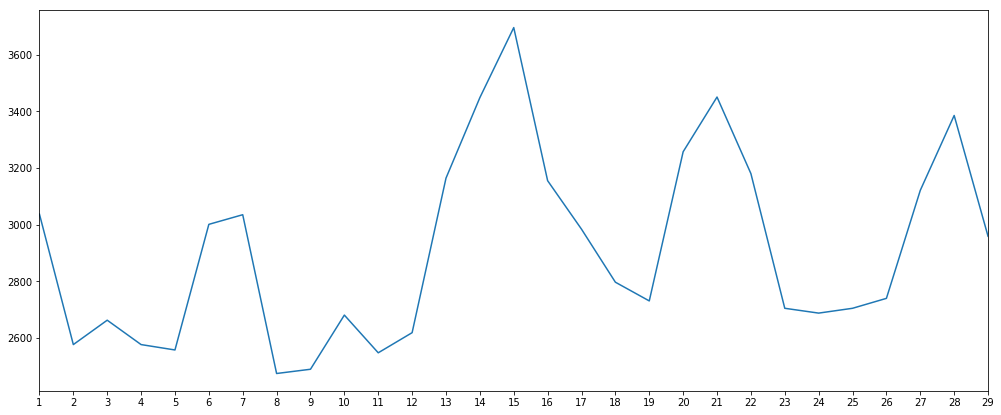

In [51]:
from pandas import Series
import matplotlib.pyplot as plt 
series = Series.from_array(feb_count,feb_days)
fig, ax = plt.subplots(figsize=(17, 7))
plt.xticks(feb_days)
plt.figsize=(20,20)
series.plot()
plt.show()

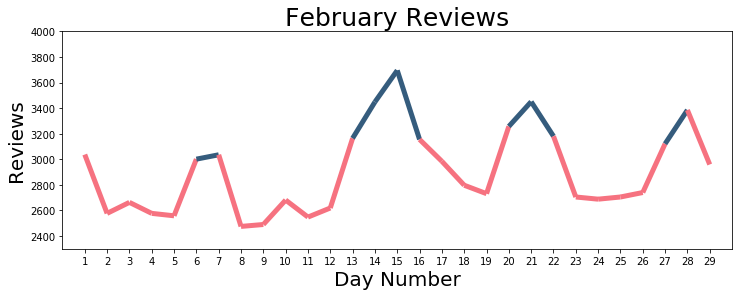

In [146]:
from pandas import Series
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from scipy.stats.mstats import mquantiles

#series = Series.from_array(feb_count,feb_days)
#fig, ax = plt.subplots(figsize=(17, 7))

# Threshold above which the line should be red
threshold = 3000
feb_daysNP = np.asarray(feb_days)
feb_countNP = np.asarray(feb_count)

# Create line segments: 1--2, 2--17, 17--20, 20--16, 16--3, etc.
segments_x = np.r_[feb_daysNP[0], feb_daysNP[1:-1].repeat(2), feb_daysNP[-1]].reshape(-1, 2)
segments_y = np.r_[feb_countNP[0], feb_countNP[1:-1].repeat(2), feb_countNP[-1]].reshape(-1, 2)

# Assign colors to the line segments
linecolors = ['#355C7D' if y_[0] > threshold and y_[1] > threshold else '#F67280'
              for y_ in segments_y]

# Stamp x,y coordinates of the segments into the proper format for the
# LineCollection
segments = [zip(x_, y_) for x_, y_ in zip(segments_x, segments_y)]

# Create figure
# Create figure
#fig, ax = plt.subplots(figsize=(17, 7))
plt.figure(figsize=(12, 4))
ax = plt.axes()
ax.set_xlabel('Day Number',fontsize=20)
ax.set_ylabel('Reviews',fontsize=20)
ax.set_title("February Reviews", fontsize =25)
# Add a collection of lines
ax.add_collection(LineCollection(segments, colors=linecolors,linewidths=5))
#ax.hlines([3000], -0, 29, color='g') #plots green horizontal line
plt.xticks(feb_daysNP)

#series.plot()
ax.set_xlim(0, 30)
ax.set_ylim(2300, 4000)
plt.show()

In [10]:
from pandas import Series
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from scipy.stats.mstats import mquantiles

def plotTimeSeries(month_days,month_reviews,pair_colors,year,month):
    # Threshold above which the line should be red
    third_Q = mquantiles(month_count)[2]
    threshold = third_Q
    
    if(len(month_days) == 0 or len(month_reviews) == 0):
        return
    
    daysNP = np.asarray(month_days)
    countNP = np.asarray(month_reviews)

    # Create line segments: 1--2, 2--17, 17--20, 20--16, 16--3, etc.
    segments_x = np.r_[daysNP[0], daysNP[1:-1].repeat(2), daysNP[-1]].reshape(-1, 2)
    segments_y = np.r_[countNP[0], countNP[1:-1].repeat(2), countNP[-1]].reshape(-1, 2)

    # Assign colors to the line segments
    linecolors = [pair_colors[0] if y_[0] > threshold and y_[1] > threshold else pair_colors[1]
                  for y_ in segments_y]

    # Stamp x,y coordinates of the segments into the proper format for the
    # LineCollection
    segments = [zip(x_, y_) for x_, y_ in zip(segments_x, segments_y)]

    # Create figure
    # Create figure
    #fig, ax = plt.subplots(figsize=(17, 7))
    plt.figure(figsize=(12, 4))
    ax = plt.axes()
    ax.set_xlabel('Day Number',fontsize=20)
    ax.set_ylabel('Reviews',fontsize=20)
    ax.set_title(month + " " + year + " Reviews", fontsize =25)
    # Add a collection of lines
    ax.add_collection(LineCollection(segments, colors=linecolors,linewidths=5))
    #ax.hlines([3000], -0, 29, color='g') #plots green horizontal line
    plt.xticks(daysNP)

    ax.set_xlim(1, 31)
    ax.set_ylim(np.min(countNP),np.max(countNP))
    #plt.show()

In [49]:
def plotTimeSeriesImproved(month_days,month_reviews,pair_colors,year,month):
    # Threshold above which the line should be red
    third_Q = mquantiles(month_reviews)[2]
    threshold = third_Q
    
    if(len(month_days) == 0 or len(month_reviews) == 0):
        return
    
    daysNP = np.asarray(month_days)
    countNP = np.asarray(month_reviews)

    # Create line segments: 1--2, 2--17, 17--20, 20--16, 16--3, etc.
    segments_x = np.r_[daysNP[0], daysNP[1:-1].repeat(2), daysNP[-1]].reshape(-1, 2)
    segments_y = np.r_[countNP[0], countNP[1:-1].repeat(2), countNP[-1]].reshape(-1, 2)
    
    def raisingPike(y0,y1,threshold):
        if y0 >= threshold and y1 >= threshold:
            return True
        elif y0 <= threshold and y1 >= threshold:
            return True
        
        return False

    # Assign colors to the line segments
    linecolors = [pair_colors[0] if raisingPike(y_[0],y_[1],threshold) else pair_colors[1]
                  for y_ in segments_y]

    # Stamp x,y coordinates of the segments into the proper format for the
    # LineCollection
    segments = [zip(x_, y_) for x_, y_ in zip(segments_x, segments_y)]

    # Create figure
    # Create figure
    #fig, ax = plt.subplots(figsize=(17, 7))
    plt.figure(figsize=(12, 4))
    ax = plt.axes()
    ax.set_xlabel('Day Number',fontsize=20)
    ax.set_ylabel('Reviews',fontsize=20)
    ax.set_title(month + " " + year + " Reviews", fontsize =25)
    # Add a collection of lines
    ax.add_collection(LineCollection(segments, colors=linecolors,linewidths=5))
    ax.hlines([threshold], -0, 31, color='#606470') #plots green horizontal line
    plt.xticks(daysNP)

    ax.set_xlim(1, 31)
    ax.set_ylim(np.min(countNP),np.max(countNP))
    #plt.show()

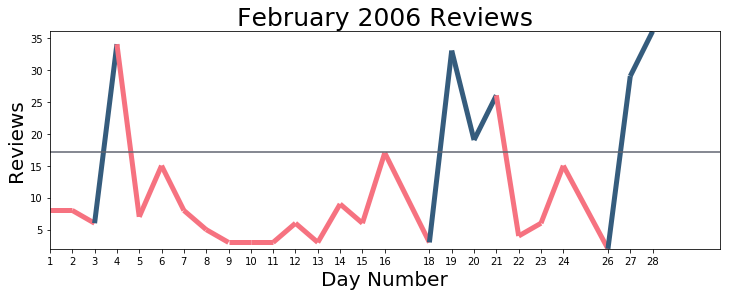

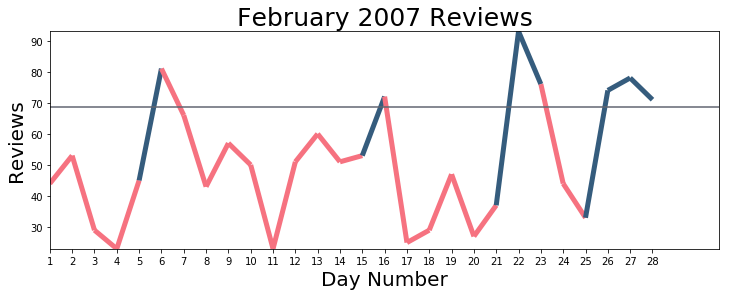

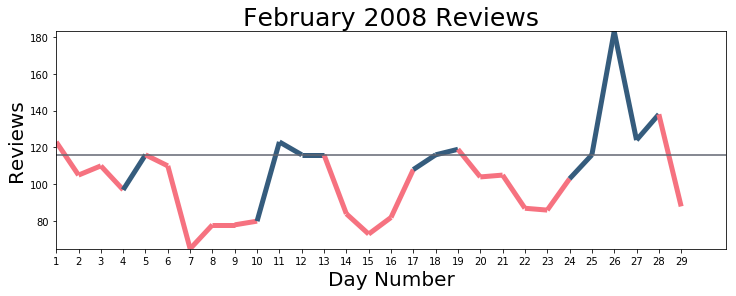

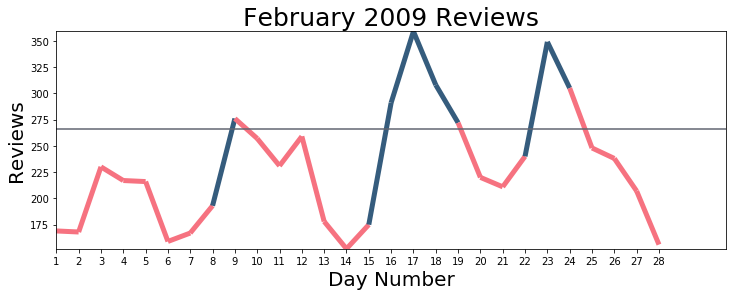

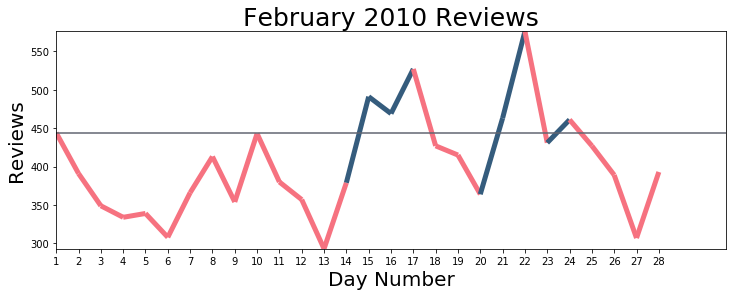

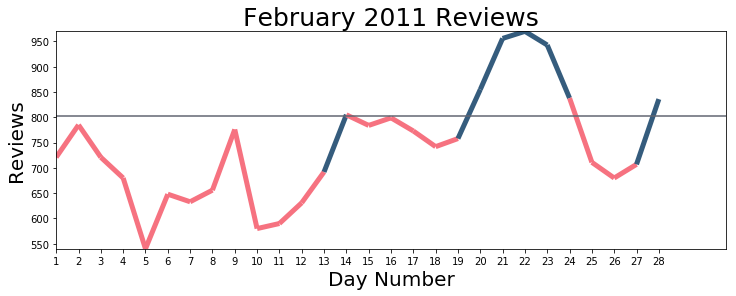

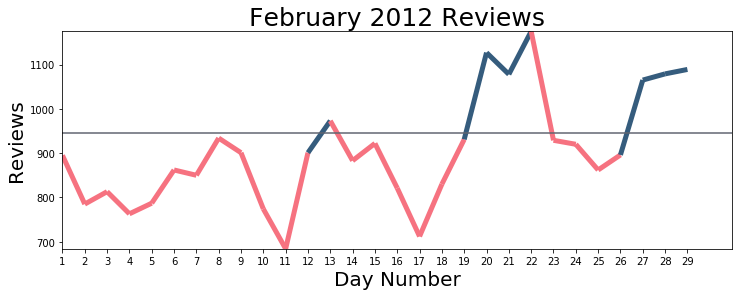

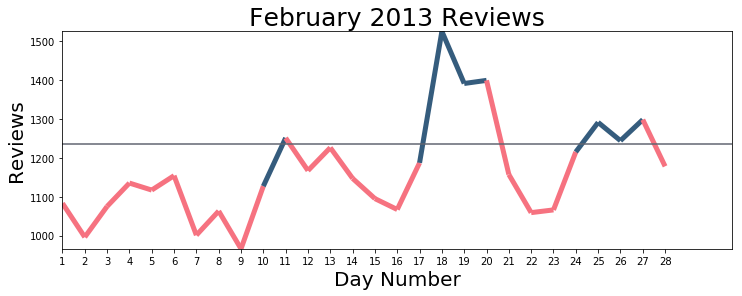

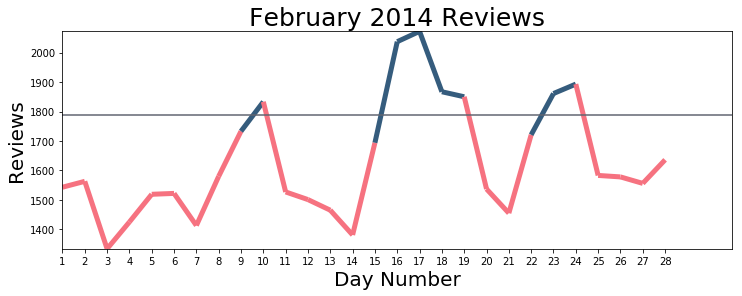

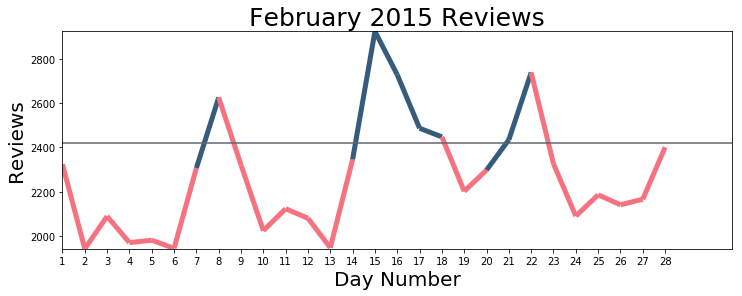

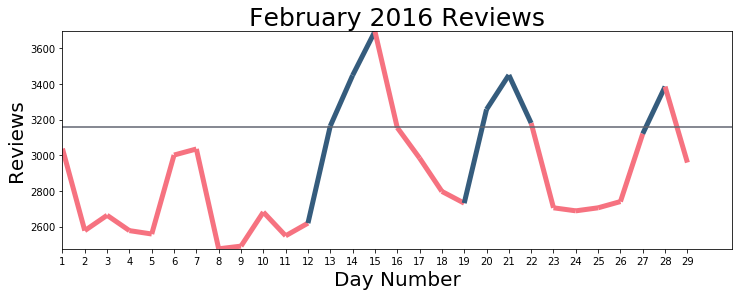

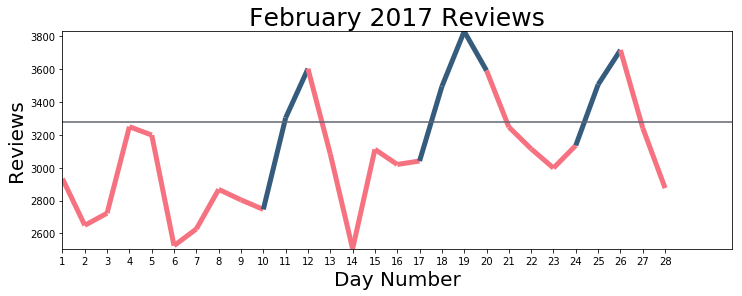

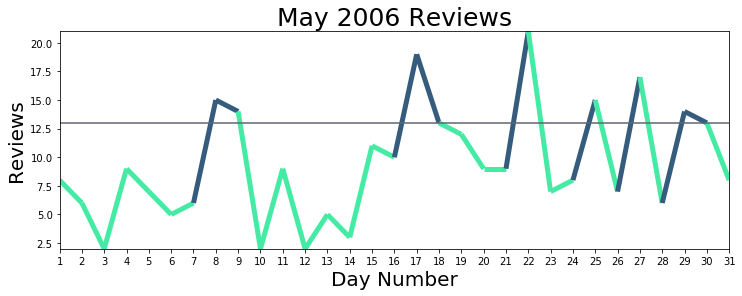

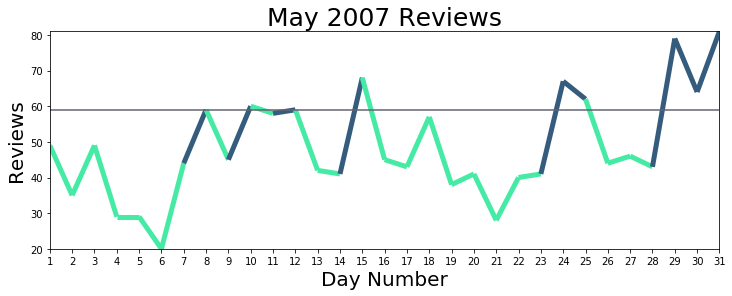

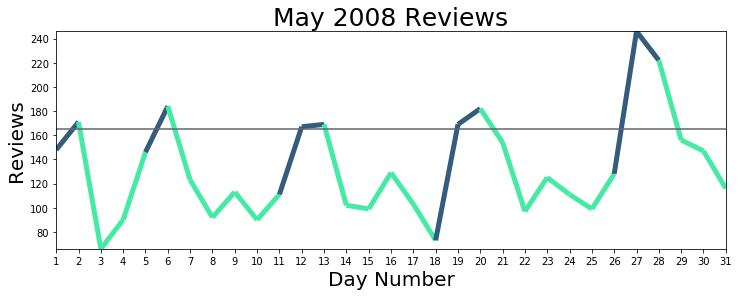

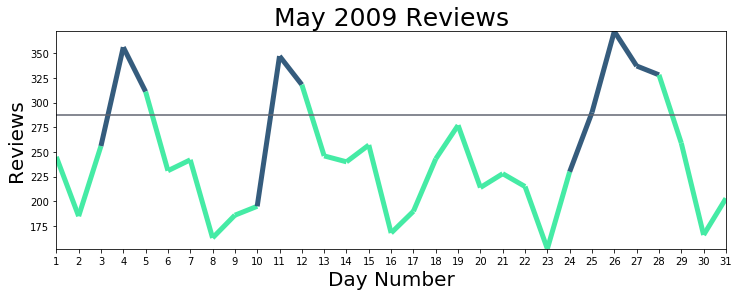

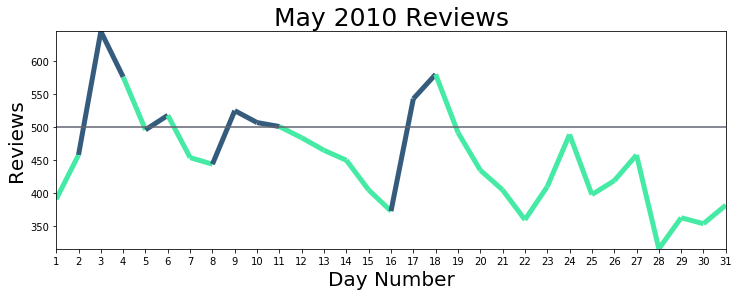

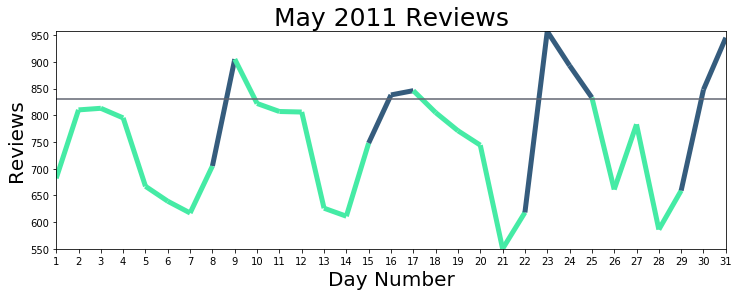

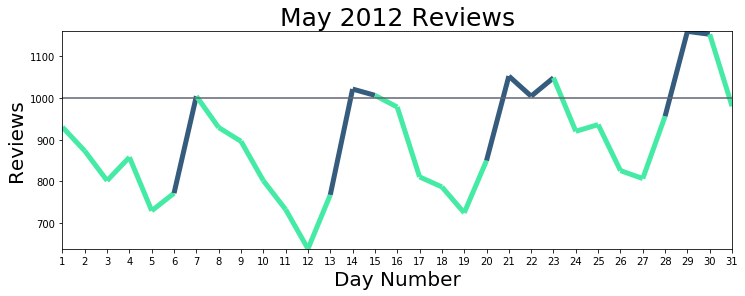

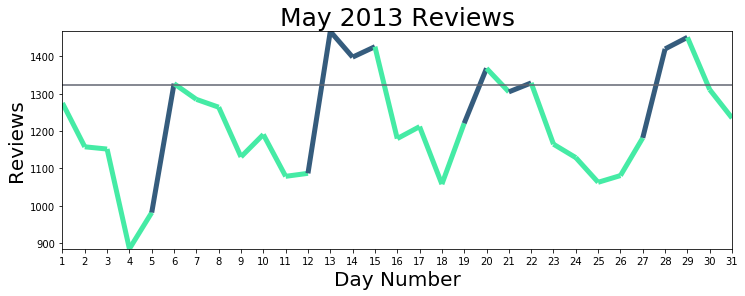

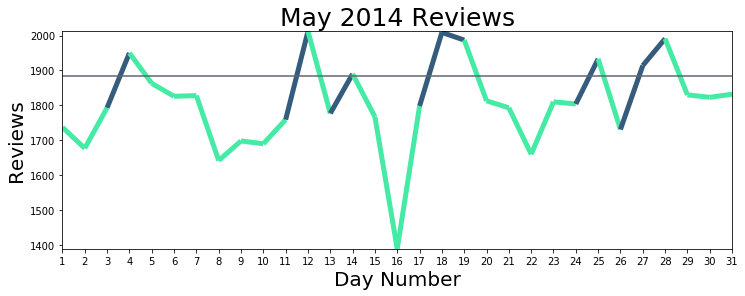

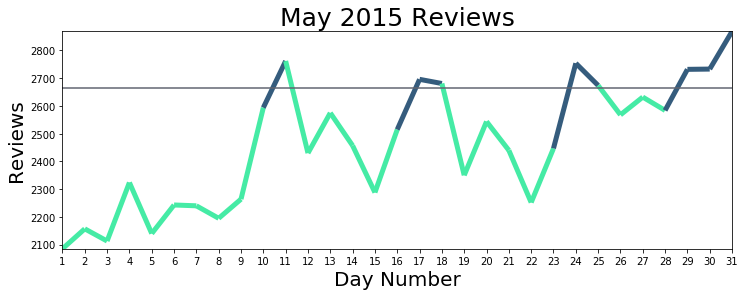

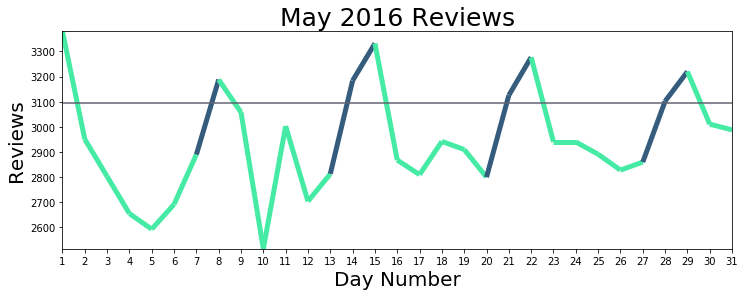

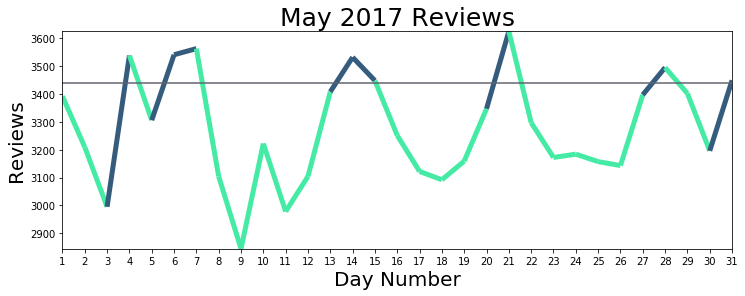

In [14]:
#DO THE SAME FOR SEVERAL MONTHS
seriesToPlot = []
for month,color_pair,month_name in zip([2,5],[('#355C7D','#F67280'),('#355C7D','#45EBA5')],['February','May']):
    #for month,color_pair,month_name in zip([2],[('#355C7D','#F67280')],['February']):
    
    for year in range(6,18): #was 18
        month_days = []
        for day in range(1,32):
            date = '20' + ("0"+str(year) if year < 10 else str(year)) +'-'+ ("0"+str(month) if month < 10 else str(month)) + '-' + ("0"+str(day) if day < 10 else str(day))
            month_days.append(date)
        
        #Get rdd
        month_rdd = dates_rdd.filter(lambda row: row[0] in month_days)
        
        #From dataframe
        month_df = sqlContext.createDataFrame(month_rdd, schema)

        month_df = month_df.select(month_df['Date'].cast(DateType()), 
                              month_df['Number_of_Reviews'].cast(IntegerType())).cache()
        month_df = month_df.orderBy('Date')
        
        #Get days and reviews for those days
        month_days = month_df.select("Date").rdd.flatMap(lambda x: x).collect()
#         for day in month_count:
#             print(day)
        month_days = map(lambda x: x.day,month_days)
        month_count = month_df.select("Number_of_Reviews").rdd.flatMap(lambda x: x).collect()
        
        #seriesToPlot.append((month_days,month_count))
        
        plotTimeSeriesImproved(month_days,month_count,color_pair,"20" + ("0"+str(year) if year < 10 else str(year)), month_name)
        plt.show()

In [26]:
#DO THE SAME FOR SEVERAL MONTHS
seriesToPlot = []
for month,color_pair,month_name in zip([2,5],[('#355C7D','#F67280'),('#355C7D','#45EBA5')],['February','May']):
    #for month,color_pair,month_name in zip([2],[('#355C7D','#F67280')],['February']):
    
    for year in range(6,18): #was 18
        month_days = []
        for day in range(1,32):
            date = '20' + ("0"+str(year) if year < 10 else str(year)) +'-'+ ("0"+str(month) if month < 10 else str(month)) + '-' + ("0"+str(day) if day < 10 else str(day))
            month_days.append(date)
        
        #Get rdd
        month_rdd = dates_rdd.filter(lambda row: row[0] in month_days)
        
        #From dataframe
        month_df = sqlContext.createDataFrame(month_rdd, schema)

        month_df = month_df.select(month_df['Date'].cast(DateType()), 
                              month_df['Number_of_Reviews'].cast(IntegerType())).cache()
        month_df = month_df.orderBy('Date')
        
        #Get days and reviews for those days
        month_days = month_df.select("Date").rdd.flatMap(lambda x: x).collect()
#         for day in month_count:
#             print(day)
        month_days = map(lambda x: x.day,month_days)
        month_count = month_df.select("Number_of_Reviews").rdd.flatMap(lambda x: x).collect()
        
        seriesToPlot.append((month_days,month_count))
        
        #plotTimeSeriesImproved(month_days,month_count,color_pair,"20" + ("0"+str(year) if year < 10 else str(year)), month_name)
        #plt.show()

In [47]:
#====================================
def plotTimeSeriesImprovedIMG(month_days,month_reviews,pair_colors,year,month):
    from scipy.stats.mstats import mquantiles
    # Threshold above which the line should be red
    third_Q = mquantiles(month_reviews)[2]
    threshold = third_Q
    print(threshold)
    
    if(len(month_days) == 0 or len(month_reviews) == 0):
        return
    
    daysNP = np.asarray(month_days)
    countNP = np.asarray(month_reviews)

    # Create line segments: 1--2, 2--17, 17--20, 20--16, 16--3, etc.
    segments_x = np.r_[daysNP[0], daysNP[1:-1].repeat(2), daysNP[-1]].reshape(-1, 2)
    segments_y = np.r_[countNP[0], countNP[1:-1].repeat(2), countNP[-1]].reshape(-1, 2)
    
    def raisingPike(y0,y1,threshold):
        if y0 >= threshold and y1 >= threshold:
            return True
        elif y0 <= threshold and y1 >= threshold:
            return True
        
        return False

    # Assign colors to the line segments
    linecolors = [pair_colors[0] if raisingPike(y_[0],y_[1],threshold) else pair_colors[1]
                  for y_ in segments_y]

    # Stamp x,y coordinates of the segments into the proper format for the
    # LineCollection
    segments = [zip(x_, y_) for x_, y_ in zip(segments_x, segments_y)]

    # Create figure
    # Create figure
    #fig, ax = plt.subplots(figsize=(17, 7))
    plt.figure(figsize=(12, 4))
    ax = plt.axes()
    ax.set_xlabel('Day Number',fontsize=20)
    ax.set_ylabel('Reviews',fontsize=20)
    ax.set_title(month + " " + year + " Reviews", fontsize =25)
    # Add a collection of lines
    
    ax.add_collection(LineCollection(segments, colors=linecolors,linewidths=5))
    ax.hlines([threshold], -0, 31, color='#606470') #plots green horizontal line
    plt.xticks(daysNP)
   
    ax.set_xlim(1, 31)
    ax.set_ylim(np.min(countNP),np.max(countNP))

17.1


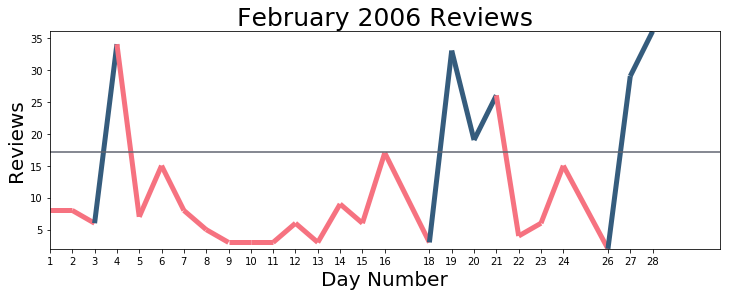

68.75


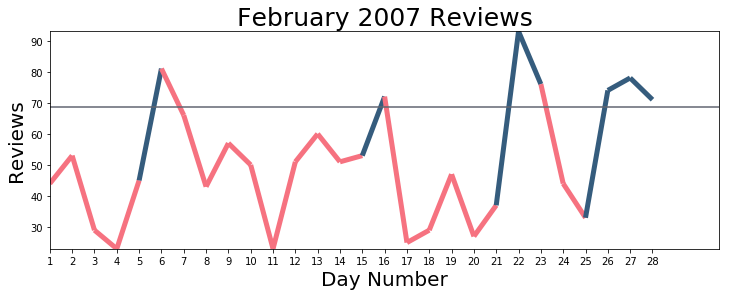

116.0


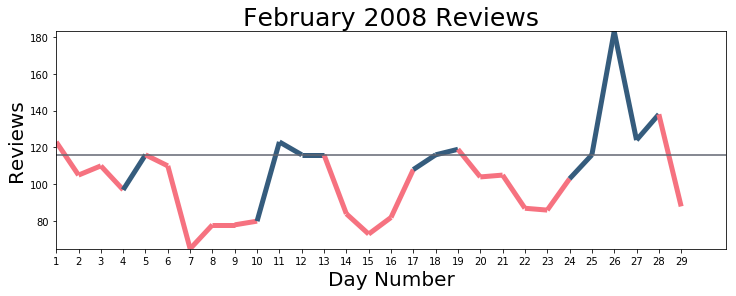

266.15


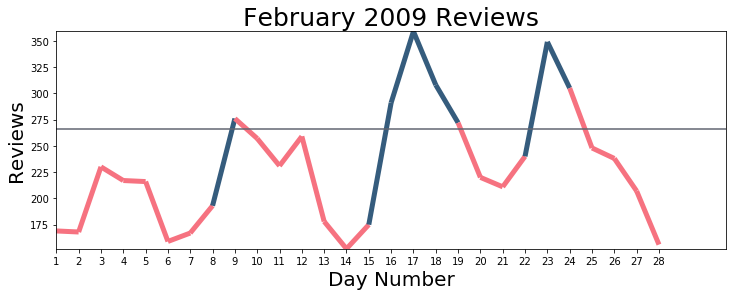

443.55


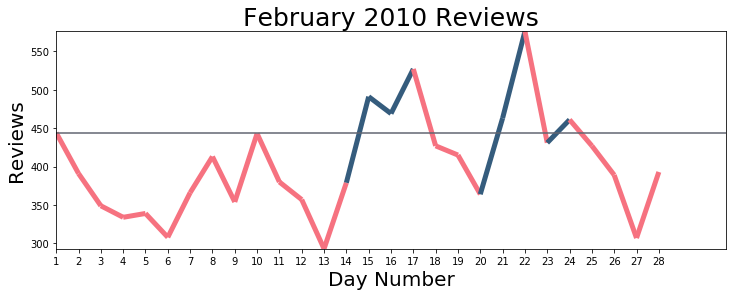

802.3


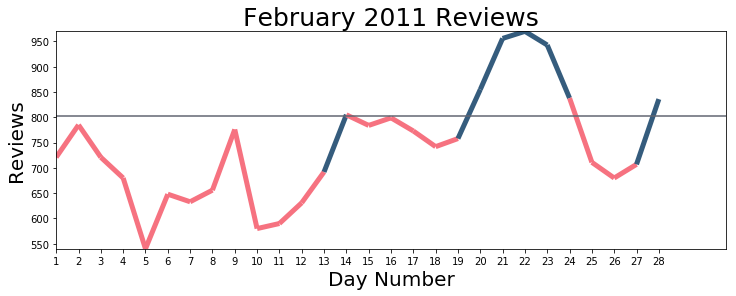

945.7


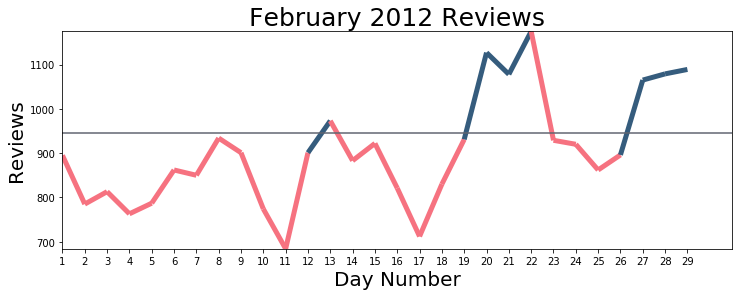

1235.9


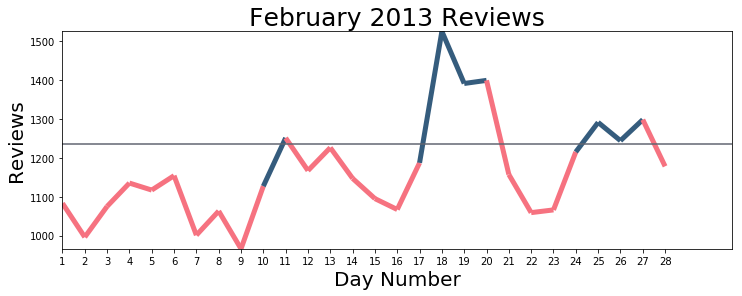

1788.0


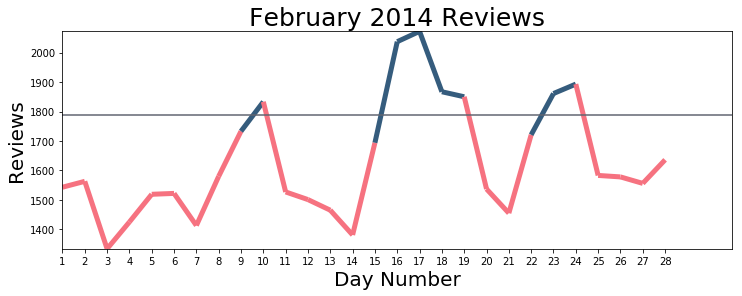

2419.7


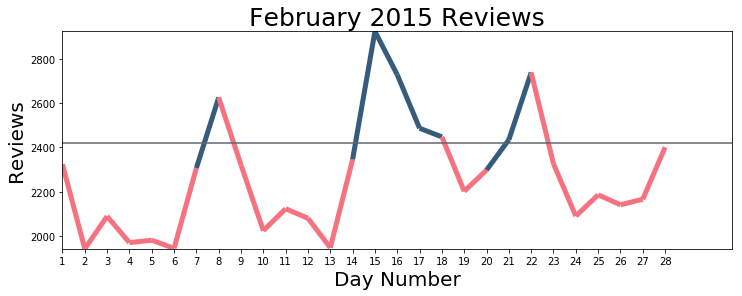

3157.7


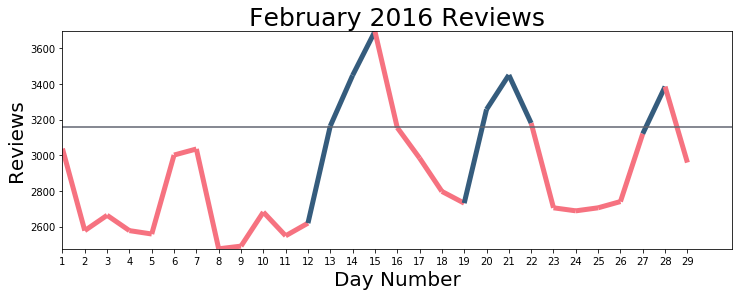

3279.7


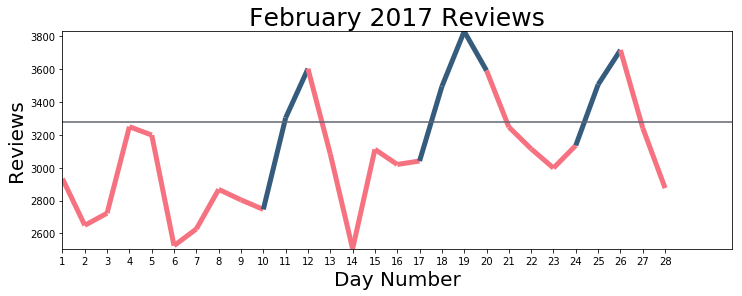

13.0


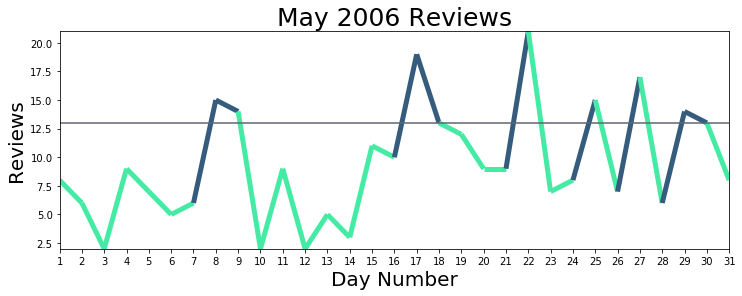

59.0


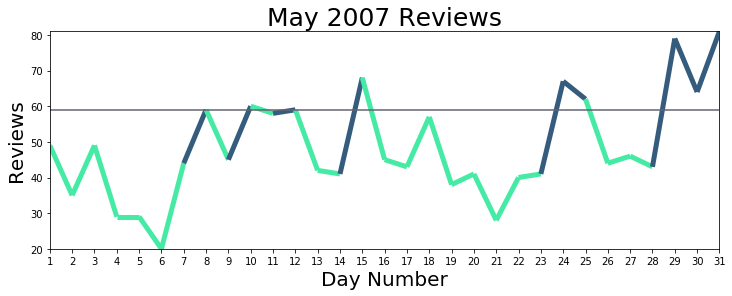

164.8


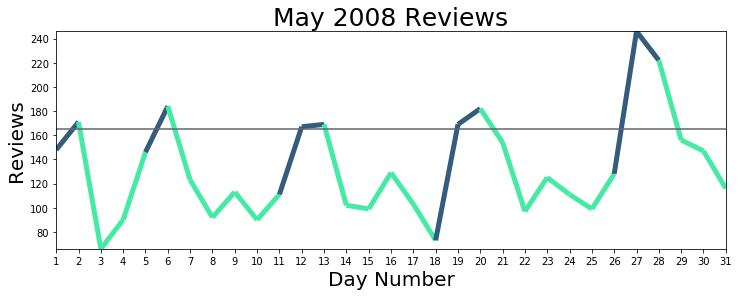

287.4


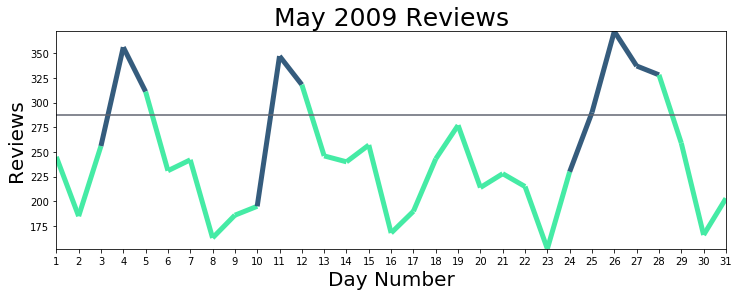

500.0


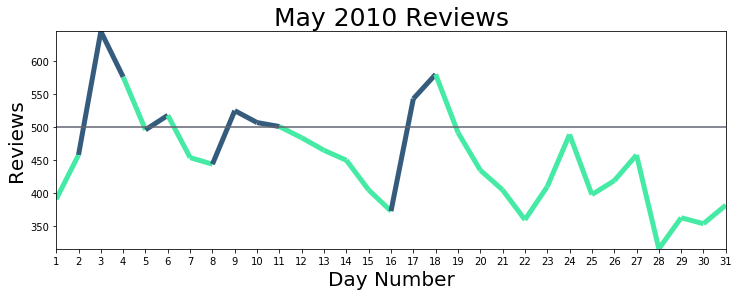

830.8


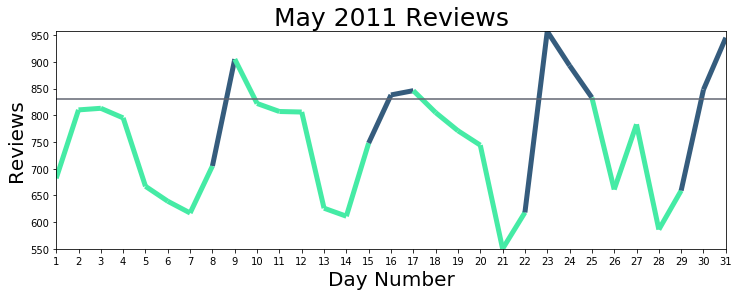

999.2


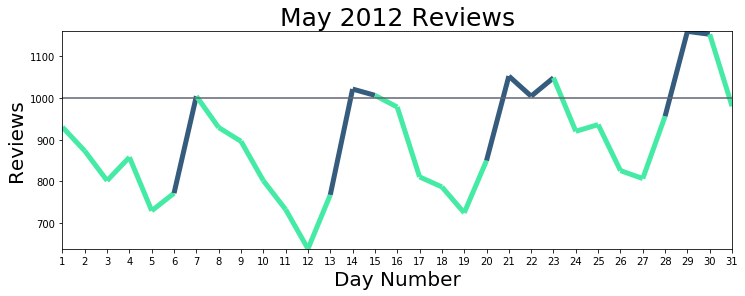

1323.8


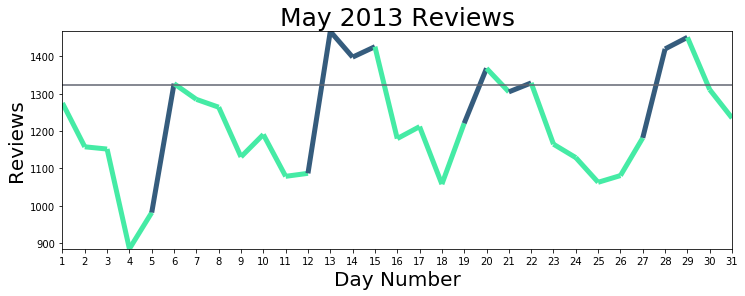

1884.6


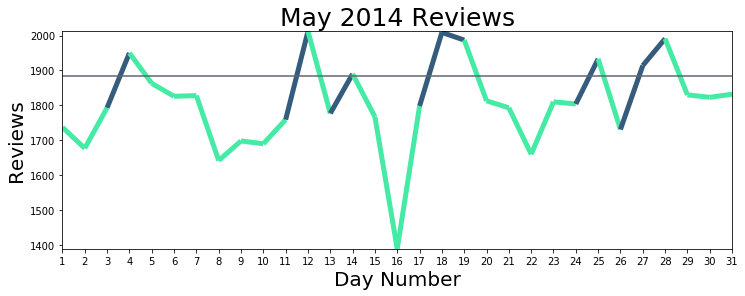

2665.6


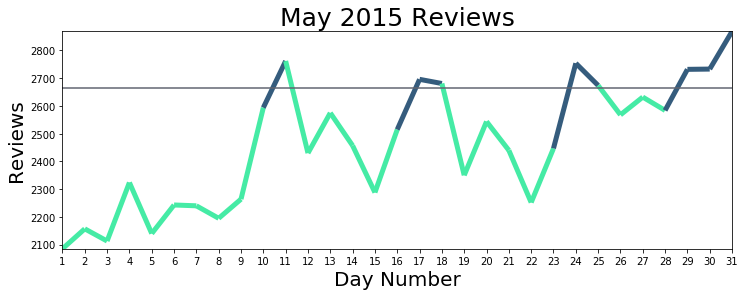

3093.2


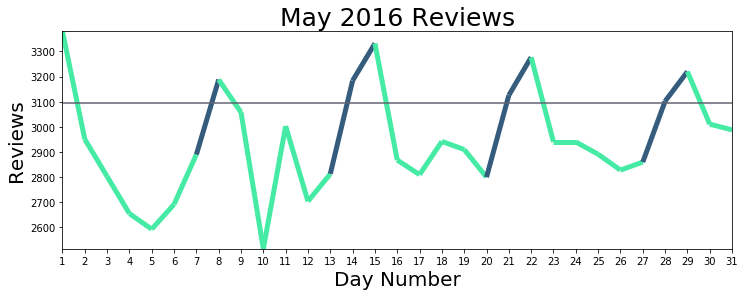

3440.0


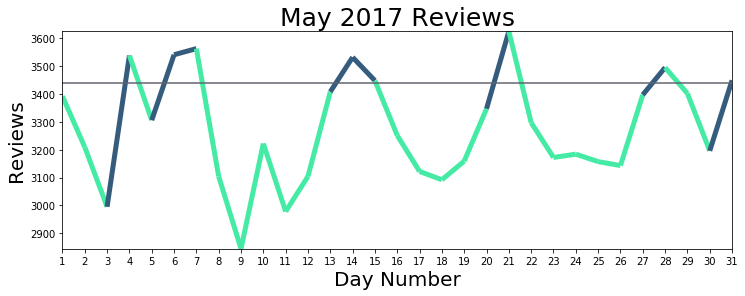

In [53]:
from pandas import Series
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection


february = seriesToPlot[0:12]
may = seriesToPlot[12:]

for month,color_pair,month_name,year_vals in zip([2,5],[('#355C7D','#F67280'),('#355C7D','#45EBA5')],['February','May'],[february,may]):
    #for month,color_pair,month_name in zip([2],[('#355C7D','#F67280')],['February']):
    
    for year,year_val in zip(range(6,18),year_vals): #was 18
        
        plotTimeSeriesImprovedIMG(year_val[0],year_val[1],color_pair,"20" + ("0"+str(year) if year < 10 else str(year)), month_name)
        
        #PROCESS TO SAVE IMAGE
        fig1 = plt.gcf()
        plt.show()
        plt.draw()
        fig1.savefig(month_name+ "20" + ("0"+str(year) if year < 10 else str(year)) +'.png', dpi=100)

In [51]:
def plotTimeSeriesImprovedDual(month_days,month_reviews,month_label,pair_colors,year,month):
    # Threshold above which the line should be red
    third_Q = mquantiles(month_reviews)[2]
    threshold = third_Q
    
    if(len(month_days) == 0 or len(month_reviews) == 0):
        return
    
    daysNP = np.asarray(month_days)
    countNP = np.asarray(month_reviews)
    
    dayslabelNP = map(lambda x: str(x),month_label)

    # Create line segments: 1--2, 2--17, 17--20, 20--16, 16--3, etc.
    segments_x = np.r_[daysNP[0], daysNP[1:-1].repeat(2), daysNP[-1]].reshape(-1, 2)
    segments_y = np.r_[countNP[0], countNP[1:-1].repeat(2), countNP[-1]].reshape(-1, 2)
    
    def raisingPike(y0,y1,threshold):
        if y0 >= threshold and y1 >= threshold:
            return True
        elif y0 <= threshold and y1 >= threshold:
            return True
        
        return False

    # Assign colors to the line segments
    linecolors = [pair_colors[0] if raisingPike(y_[0],y_[1],threshold) else pair_colors[1]
                  for y_ in segments_y]

    # Stamp x,y coordinates of the segments into the proper format for the
    # LineCollection
    segments = [zip(x_, y_) for x_, y_ in zip(segments_x, segments_y)]

    # Create figure
    # Create figure
    #fig, ax = plt.subplots(figsize=(17, 7))
    plt.figure(figsize=(18, 5))
    ax = plt.axes()
    ax.set_xlabel('Day Number',fontsize=20)
    ax.set_ylabel('Reviews',fontsize=20)
    ax.set_title(month + year + " Reviews", fontsize =25)
    # Add a collection of lines
    ax.add_collection(LineCollection(segments, colors=linecolors,linewidths=5))
    ax.hlines([threshold], -0, 62, color='#606470') #plots green horizontal line
    plt.xticks(range(1,63), month_label, size='small')
    #plt.xticks(dayslabelNP)

    ax.set_xlim(1, 62)
    ax.set_ylim(np.min(countNP),np.max(countNP))
    #plt.show()

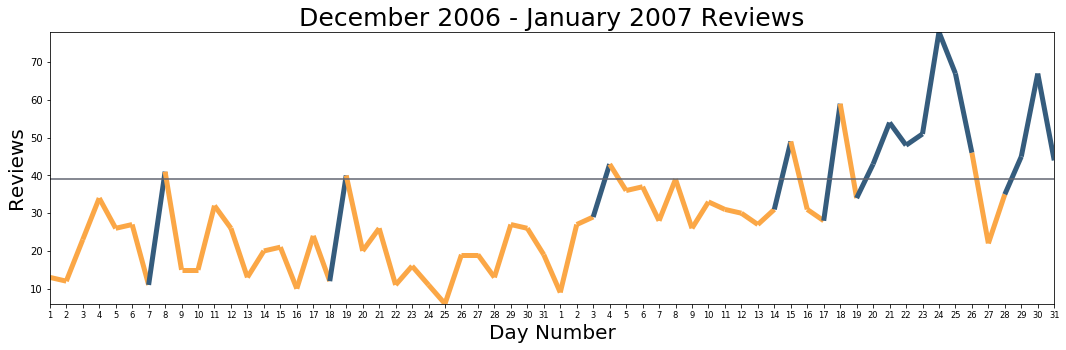

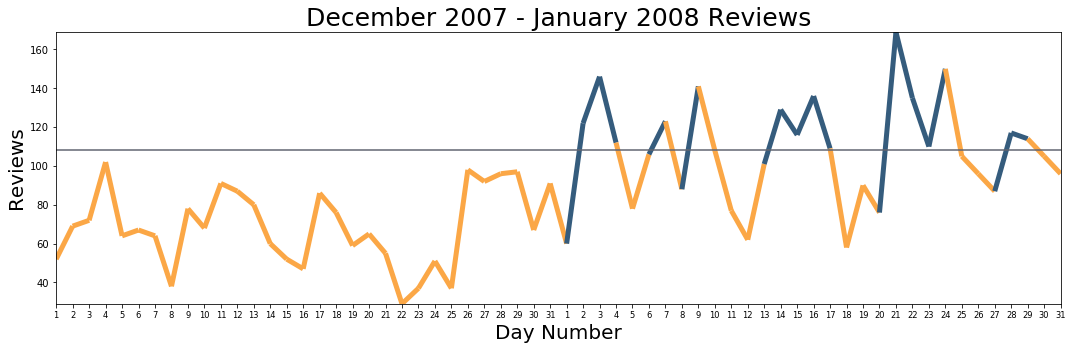

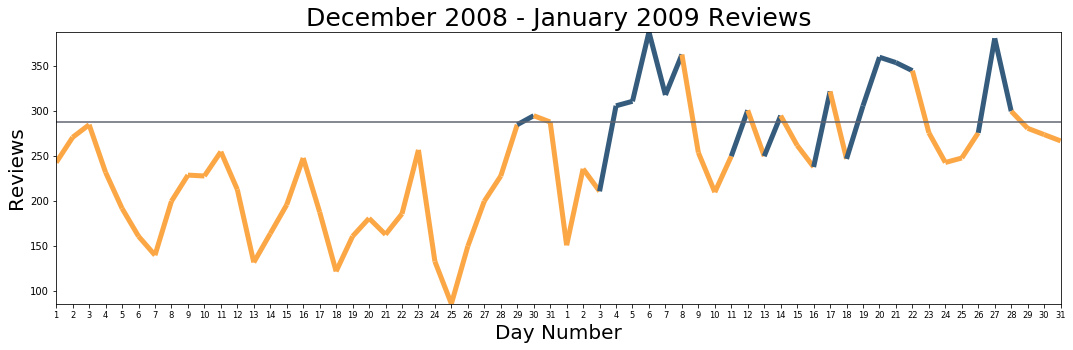

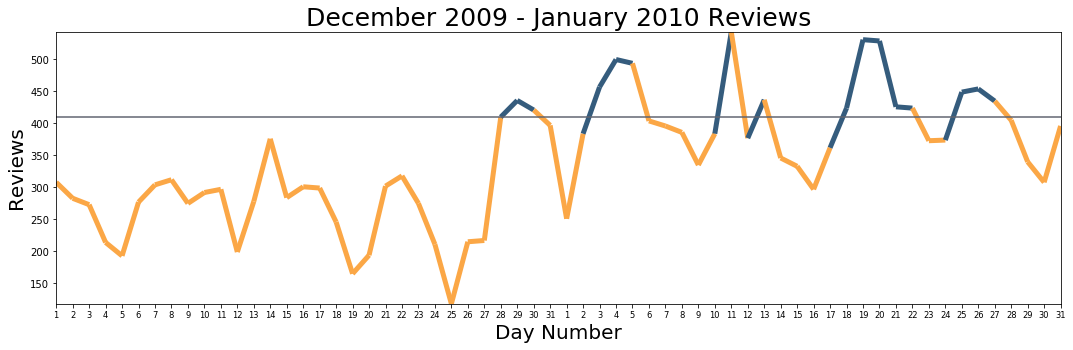

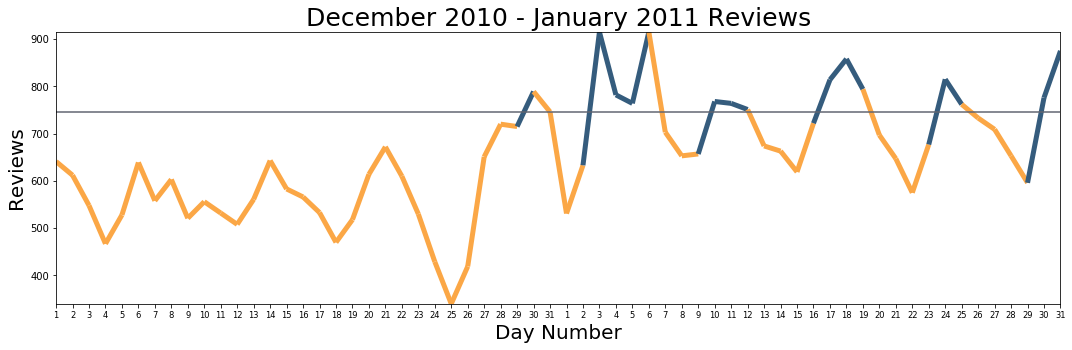

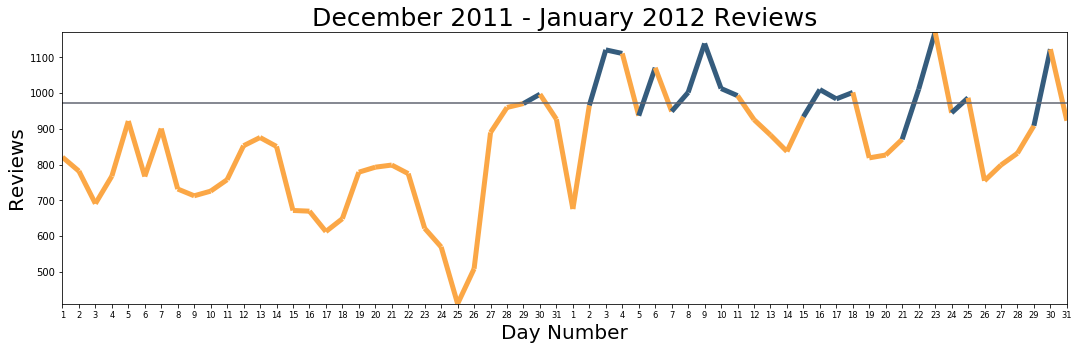

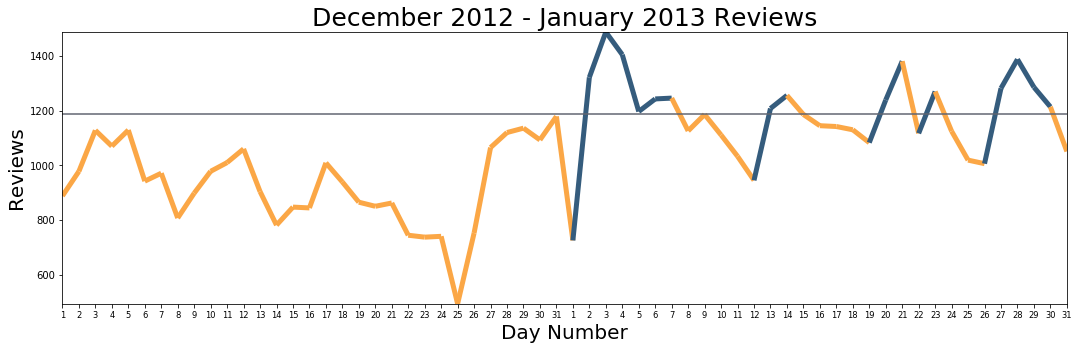

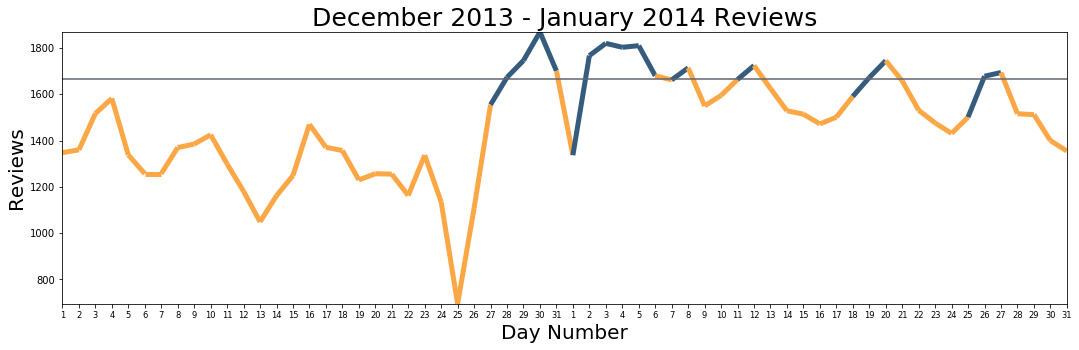

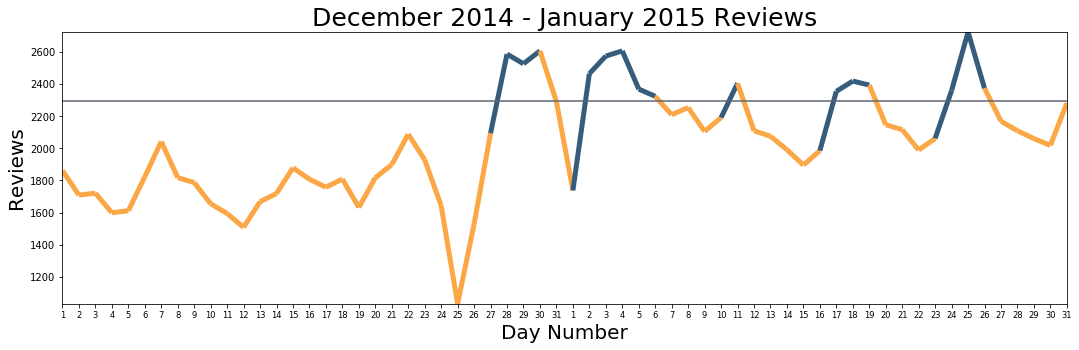

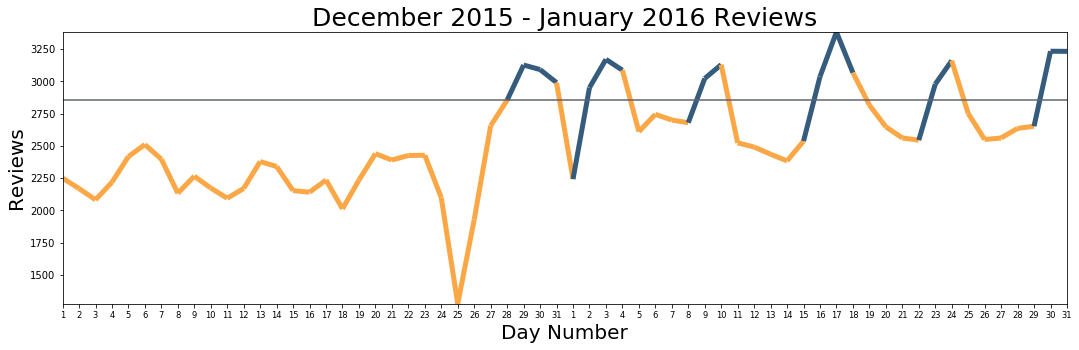

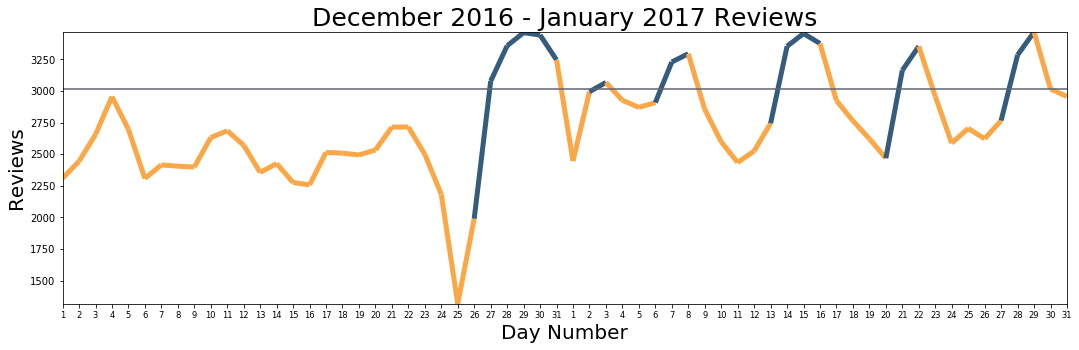

In [24]:
year_pairs = []

for i in range(6,17):
    #for i in range(6,7):
    year_pairs.append((i,i+1))
    
for year in year_pairs: 
    month_days = []
    #DECEMBER
    for day in range(1,32):
        date = '20' + ("0"+str(year[0]) if year[0] < 10 else str(year[0])) +'-12-' + ("0"+str(day) if day < 10 else str(day))
        month_days.append(date)
        
    #JANUARY    
    for day in range(1,32):
        date = '20' + ("0"+str(year[1]) if year[1] < 10 else str(year[1])) +'-01-' + ("0"+str(day) if day < 10 else str(day))
        month_days.append(date)

    #Get rdd
    month_rdd = dates_rdd.filter(lambda row: row[0] in month_days)

    #From dataframe
    month_df = sqlContext.createDataFrame(month_rdd, schema)

    month_df = month_df.select(month_df['Date'].cast(DateType()), 
                          month_df['Number_of_Reviews'].cast(IntegerType()))
    month_df = month_df.orderBy('Date')

    #Get days and reviews for those days
    month_days = month_df.select("Date").rdd.flatMap(lambda x: x).collect()
#         for day in month_count:
#             print(day)
    month_days = map(lambda x: x.day,month_days)
    
    month_count = month_df.select("Number_of_Reviews").rdd.flatMap(lambda x: x).collect()

    #seriesToPlot.append((month_days,month_count))
    month_x = range(1,63)

    plotTimeSeriesImprovedDual(month_x,month_count,month_days,('#355C7D','#FBA746'), " - January 20" + ("0"+str(year[1]) if year[1] < 10 else str(year[1])),"December 20" + ("0"+str(year[0]) if year[0] < 10 else str(year[0])),)
    plt.show()

In [76]:
#SAVE IMAGES
seriesToPlotDUAL = []
year_pairs = []

for i in range(6,17):
    #for i in range(6,7):
    year_pairs.append((i,i+1))
    
for year in year_pairs: 
    month_days = []
    #DECEMBER
    for day in range(1,32):
        date = '20' + ("0"+str(year[0]) if year[0] < 10 else str(year[0])) +'-12-' + ("0"+str(day) if day < 10 else str(day))
        month_days.append(date)
        
    #JANUARY    
    for day in range(1,32):
        date = '20' + ("0"+str(year[1]) if year[1] < 10 else str(year[1])) +'-01-' + ("0"+str(day) if day < 10 else str(day))
        month_days.append(date)

    #Get rdd
    month_rdd = dates_rdd.filter(lambda row: row[0] in month_days)

    #From dataframe
    month_df = sqlContext.createDataFrame(month_rdd, schema)

    month_df = month_df.select(month_df['Date'].cast(DateType()), 
                          month_df['Number_of_Reviews'].cast(IntegerType()))
    month_df = month_df.orderBy('Date')

    #Get days and reviews for those days
    month_days = month_df.select("Date").rdd.flatMap(lambda x: x).collect()
#         for day in month_count:
#             print(day)
    month_days = map(lambda x: x.day,month_days)
    
    month_count = month_df.select("Number_of_Reviews").rdd.flatMap(lambda x: x).collect()
    month_x = range(1,63)
    seriesToPlotDUAL.append((month_x,month_count,month_days))
   

11


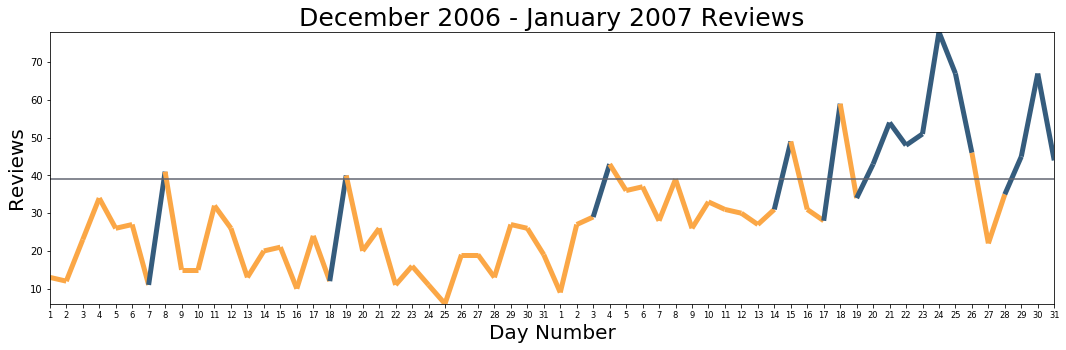

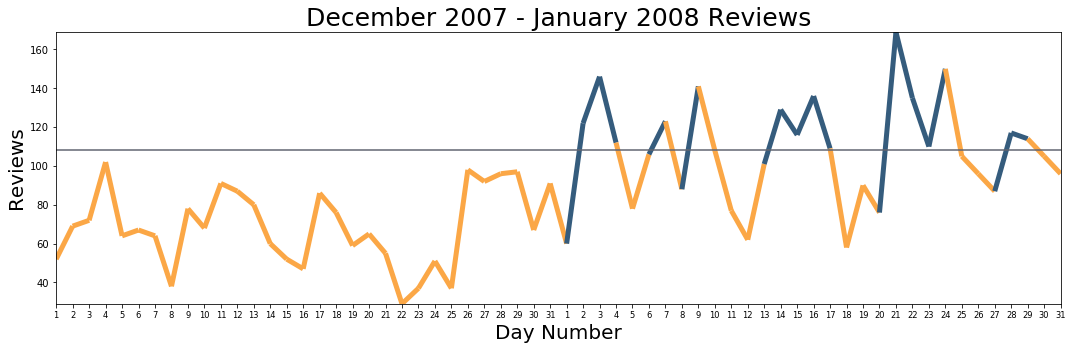

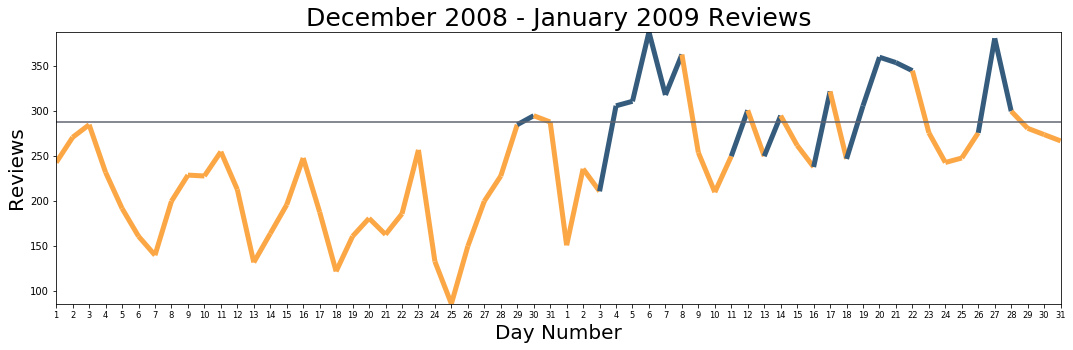

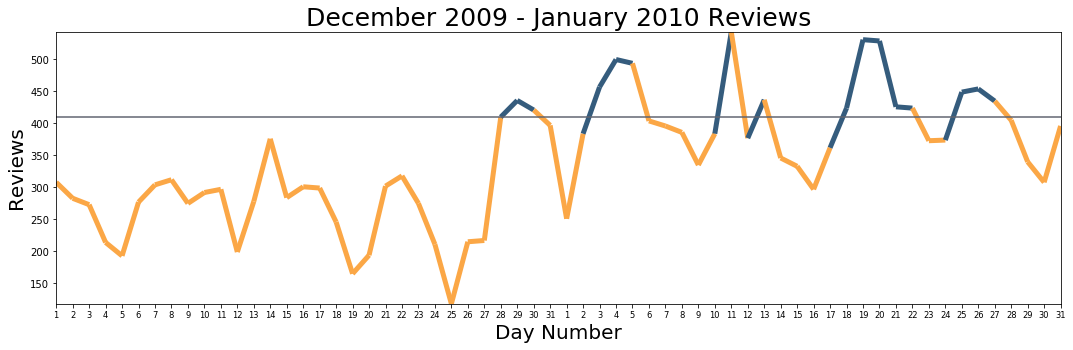

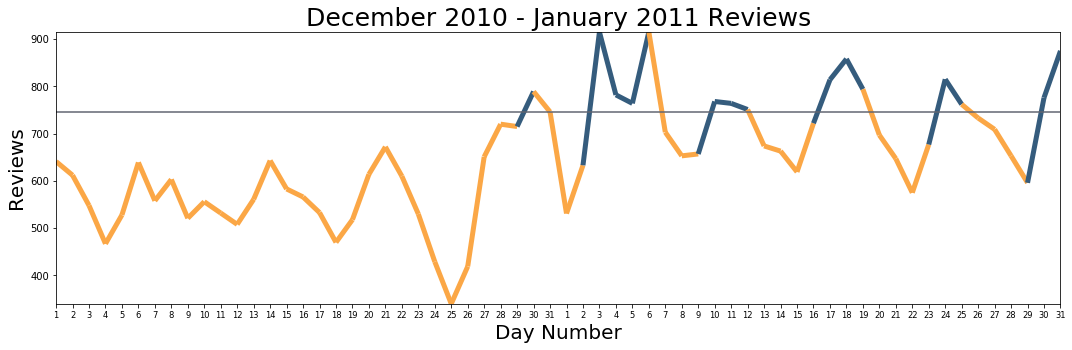

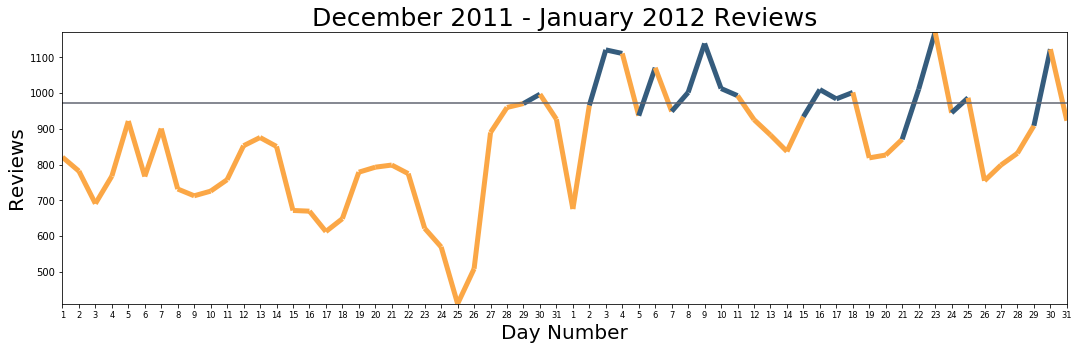

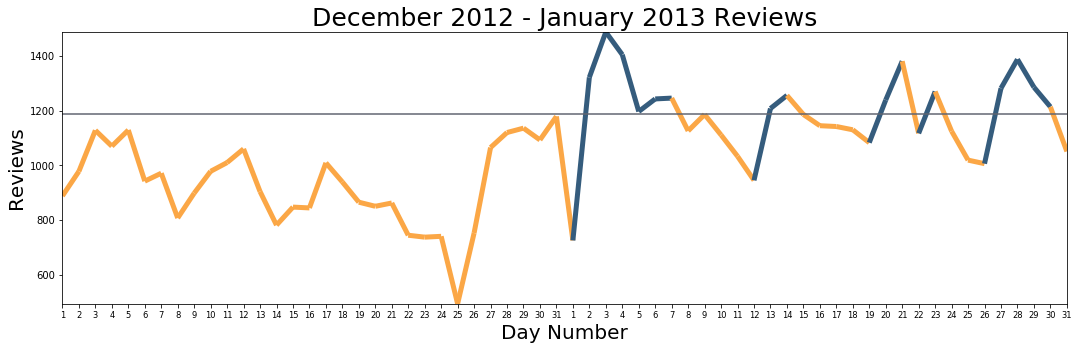

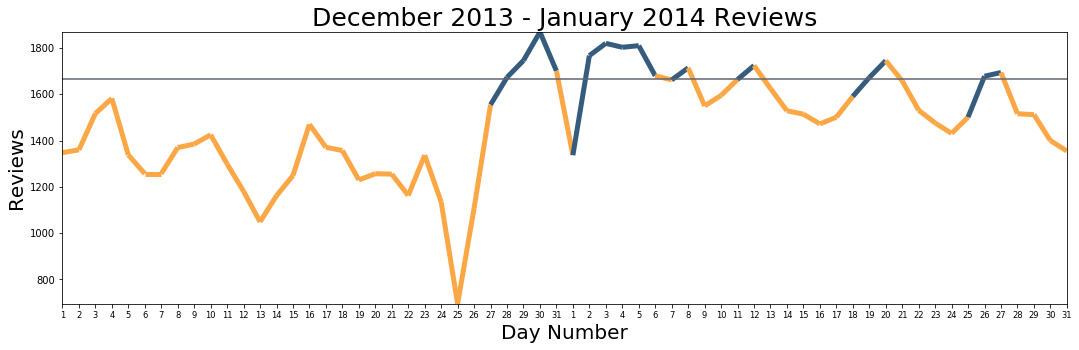

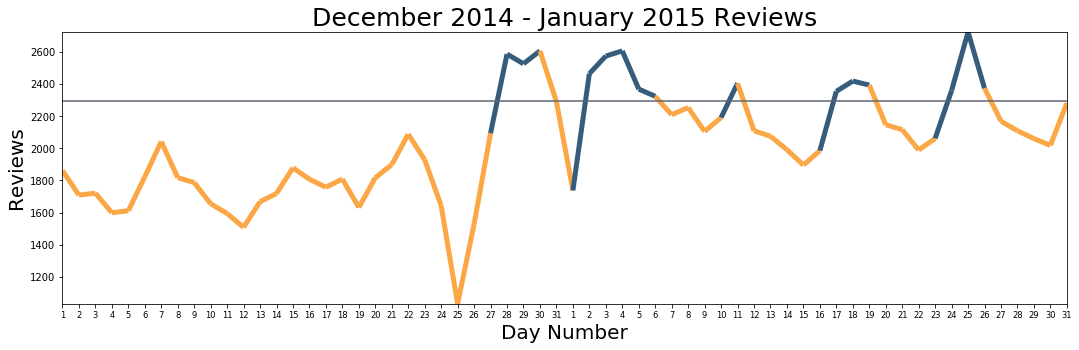

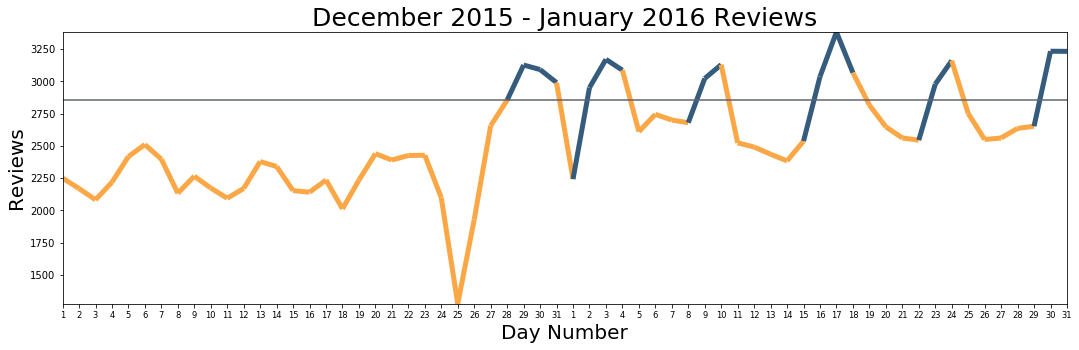

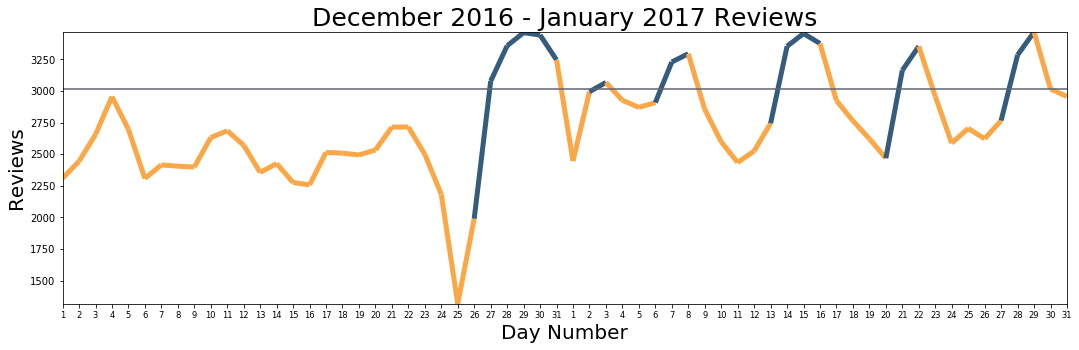

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 61407)
----------------------------------------


Traceback (most recent call last):
  File "C:\Users\migue\Anaconda2\lib\SocketServer.py", line 290, in _handle_request_noblock
    self.process_request(request, client_address)
  File "C:\Users\migue\Anaconda2\lib\SocketServer.py", line 318, in process_request
    self.finish_request(request, client_address)
  File "C:\Users\migue\Anaconda2\lib\SocketServer.py", line 331, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "C:\Users\migue\Anaconda2\lib\SocketServer.py", line 652, in __init__
    self.handle()
  File "C:\spark\python\pyspark\accumulators.py", line 235, in handle
    num_updates = read_int(self.rfile)
  File "C:\spark\python\pyspark\serializers.py", line 575, in read_int
    length = stream.read(4)
  File "C:\Users\migue\Anaconda2\lib\socket.py", line 384, in read
    data = self._sock.recv(left)
error: [Errno 10054] An existing connection was forcibly closed by the remote host


In [78]:
print(len(seriesToPlotDUAL))

for year, year_values in zip(year_pairs,seriesToPlotDUAL): 
   
    #     print(year_values[0])
    #     print(year_values[1])
    #     print(year_values[2])
    plotTimeSeriesImprovedDual(year_values[0],year_values[1],year_values[2],('#355C7D','#FBA746'), " - January 20" + ("0"+str(year[1]) if year[1] < 10 else str(year[1])),"December 20" + ("0"+str(year[0]) if year[0] < 10 else str(year[0])),)
    #PROCESS TO SAVE IMAGE
    fig1 = plt.gcf()
    plt.show()
    plt.draw()
    fig1.savefig("DEC-JAN"+ "20" + ("0"+str(year[0]) if year[0] < 10 else str(year[0])) +"-20" + ("0"+str(year[1]) if year[1] < 10 else str(year[1])) +'.png', dpi=100)